In [2]:

# Code for double pendulum; hard coded

# ------------------------------------------------------------------------------------------------------------------------ #

# import all necessary packages
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib

import sys
import traceback

from scipy.integrate import solve_ivp

# ------------------------------------------------------------------------------------------------------------------------ #

# define necessary parameters; m=mass, l=length, phi=start angle, phid=start angular velocity
m1_par = 0.5
m2_par = 0.5
l1_par = 0.5
l2_par = 0.5
phi1_par = 135
phi2_par = 160
phid1_par = 0
phid2_par = 0

# value of g; do not change !!!
g_par = 9.81

# t_start: start simulation time; t_end: end simluation time; steps: number of steps between t_start and t_end
# time vector for simulation and animation; number of samples should not be changed to ensure real-time behaviour of animation and saved gif
# 50 fps chosen as gif could not be displayed with higher values and an increase would not be noticable for humans anyway
t_start = 0
t_end = 10
steps = (t_end-t_start)*50

# ------------------------------------------------------------------------------------------------------------------------ #

# check right format of input "parameter"; anything else than int or double raise an error message
def check_parameters(parameter):
    format = str(type(parameter)).split("'")[1]
    variable_name = [name for name, value in globals().items() if value is parameter][0]
    
    if isinstance(parameter, (int, float)) == True:
        print("Parameter", variable_name, "=", parameter, "is in the right format of", format)
    else:
        msg="Parameter "+variable_name+" = "+parameter+" is in the wrong format of "+format
        sys.exit(msg)

# conversion of one variable from degree to rad; input is int or double
def deg_to_rad(phi):
    variable_name = [name for name, value in globals().items() if value is phi][0]
    phi_rad = phi*(np.pi/180)
    print("Parameter", variable_name, "=", phi, "in degrees was transformed to", phi_rad, "in rad")
    return phi_rad

# This function calculates the time derivative z_dot from the state z
# the 1st argument (the time t) is not needed here
def rhs(t, z):
    phi1, phid1, phi2, phid2 = z 
   
    phidd1 = phidd1_fnc(phi1, phid1, phi2, phid2)
    phidd2 = phidd2_fnc(phi1, phid1, phi2, phid2)

    # Return the derivative of the state vector
    z_dot = np.r_[phid1, phidd1, phid2, phidd2]
    return z_dot
    
# ------------------------------------------------------------------------------------------------------------------------ #

# check right input format of parameters
check_parameters(m1_par)
check_parameters(l1_par)
check_parameters(phi1_par)
check_parameters(m2_par)
check_parameters(l2_par)
check_parameters(phi2_par)
print("")

# do necessary precalculations from degree to rad
phi1_par = deg_to_rad(phi1_par)
phi2_par = deg_to_rad(phi2_par)
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# create symbolic parameters
params = sp.symbols("m1, l1, m2, l2, g") 
m1, l1, m2, l2, g = params

# create smybolic time and phit
t = sp.Symbol("t")  
phit1 = sp.Function("phi1")(t)
phit2 = sp.Function("phi2")(t)

# construct time derivatives
phidt1 = phit1.diff(t)
phidt2 = phit2.diff(t)
phiddt1 = phit1.diff(t, 2)
phiddt2 = phit2.diff(t, 2)

# ------------------------------------------------------------------------------------------------------------------------ #

# kinetic energy; hard coded for double pendulum
T = 0.5*m1*l1**2*phidt1**2+0.5*m2*(l1**2*phidt1**2+l2**2*phidt2**2+2*l1*l2*phidt1*phidt2*sp.cos(phit1-phit2))
print("Kinetic energy T is:", T)
print("")

# potential energy; hard coded for double pendulum; zero at lowest point
U = m1*g*l1*(1-sp.cos(phit1)) + m2*g*(l1*(1-sp.cos(phit1)) + l2*(1-sp.cos(phit2)))
print("Potential energy U is:", U)
print("")

# Lagrangian
L = T - U  

# removes unnecessary factors and digits (in this case factors of 1.0)
L = sp.nsimplify(L)
T = sp.nsimplify(T)
U = sp.nsimplify(U)

# create latex expression of L, T and U
L_latex = sp.latex(L)
T_latex = sp.latex(T)
U_latex = sp.latex(U)

# check intermediate results
print("Lagrangian is:", L)
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# perform simplifications of expression L
L = L.expand()
L = sp.trigsimp(L)

# auxiliary expressions for Lagrange Equations
L_d_phi1 = L.diff(phit1)
L_d_phi2 = L.diff(phit2)
L_d_phid1 = L.diff(phidt1)
L_d_phid2 = L.diff(phidt2)
DL_d_phid1 = L_d_phid1.diff(t)
DL_d_phid2 = L_d_phid2.diff(t)

# right hand side of the equations of motion (left hand side is zero)
Eq1 =  DL_d_phid1 - L_d_phi1
Eq2 =  DL_d_phid2 - L_d_phi2

# create latex expression of Eq
Eq1_latex = sp.latex(Eq1)
Eq2_latex = sp.latex(Eq2)

# check intermediate results
print("First Lagrange equation is:", Eq1)
print("")
print("Second Lagrange equation is:", Eq2)
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# list of accelerations
acc = [phiddt1, phiddt2]

# solve equations for acceleration symbols
res = sp.solve([Eq1, Eq2], acc)

print("The variable `res` (equations solved for accelerations) has the following values:")
entry1 = res[list(res.keys())[0]]
entry2 = res[list(res.keys())[1]]
print("")
print(entry1)
print("")
print(entry2)
print("")

# symbolic expression for acceleration
phidd_expr1 = entry1
phidd_expr2 = entry2

# ------------------------------------------------------------------------------------------------------------------------ #

# create symbols (so far we had functions depending on t):
phi1, phid1, phidd1, phi2, phid2, phidd2 = sp.symbols("phi1, phid1, phidd1, phi2, phid2, phidd2")

# list for replacements; in each case a 2-tuple: (t-dependent function, symbol)
# note: Substitute highest time derivatives first (accelerations)
rplmts = [(phiddt1, phidd1), (phidt1, phid1), (phit1, phi1), (phiddt2, phidd2), (phidt2, phid2), (phit2, phi2)]

# replace parameter symbols with start values
params_values = [(m1, m1_par), (l1, l1_par), (m2, m2_par), (l2, l2_par), (g, g_par)]

# perform subsitution and save result in variables
phidd1_expr_num = phidd_expr1.subs(rplmts+params_values)
phidd2_expr_num = phidd_expr2.subs(rplmts+params_values)

# generation of the Python functions using sp.lambdify
phidd1_fnc = sp.lambdify([phi1, phid1, phi2, phid2], phidd1_expr_num, modules="numpy")
phidd2_fnc = sp.lambdify([phi1, phid1, phi2, phid2], phidd2_expr_num, modules="numpy")

# ------------------------------------------------------------------------------------------------------------------------ #

# time vector for numeric simulation
tt = np.linspace(t_start, t_end, steps)

# start conditions for angle and angular velocity
zz0 = np.array([phi1_par, phid1_par, phi2_par, phid2_par])

# do the numerical integration
res = solve_ivp(rhs, (tt[0], tt[-1]), zz0, t_eval=tt, rtol=1e-5)

print("Numerical integration was sucessful")
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# Unpacking of individual state components.
# Arrays are always unpacked along the 1st axis (rows).
phi1, phid1, phi2, phid2 = res.y

# kinetic energy with solved variables for visualization
T_sol = 0.5*m1_par*l1_par**2*phid1**2+0.5*m2_par*(l1_par**2*phid1**2+l2_par**2*phid2**2+2*l1_par*l2_par*phid1*phid2*np.cos(phi1-phi2))
# potential energy with solved variables for visualization
U_sol = m1_par*g_par*l1_par*(1-np.cos(phi1)) + m2_par*g_par*(l1_par*(1-np.cos(phi1)) + l2_par*(1-np.cos(phi2)))

# conversion of angle and angular velocity from rad or rad/s to degree or degree/s
phi1_deg=phi1/(np.pi/180)
phi2_deg=phi2/(np.pi/180)
phid1_deg=phid1/(np.pi/180)
phid2_deg=phid2/(np.pi/180)

print("Conversion of variables sucessful")
print("")

# calculate x and y from solved angle
x1 = np.sin(phi1)*l1_par
y1 = -l1_par*np.cos(phi1)
x2 = np.sin(phi1)*l1_par + np.sin(phi2)*l2_par
y2 = -l1_par*np.cos(phi1) -l2_par*np.cos(phi2)

# ------------------------------------------------------------------------------------------------------------------------ #

# txt file is created here if not already existing; otherwise just open the file
f = open("Langrangian_and_Lagrange_Equation_(Double_Pendulum).txt", "w")

# write Lagrangian in tex notation with text
f.write("Lagrangian is:\n")
f.write(L_latex)

# spacing
f.write("\n")
f.write("\n")

# write Lagrange Equations in tex notation with text
f.write("First Lagrange Equation is:\n")
f.write(Eq1_latex)

# spacing
f.write("\n")
f.write("\n")

# write Lagrange Equations in tex notation with text
f.write("Second Lagrange Equation is:\n")
f.write(Eq2_latex)

# spacing
f.write("\n")
f.write("\n")

# write potential Energy U in tex notation with text
f.write("Potential Energy U is:\n")
f.write(U_latex)

# spacing
f.write("\n")
f.write("\n")

# write kinetic Energy T in tex notation with text
f.write("Kinetic Energy L is:\n")
f.write(T_latex)

# close file again
f.close()


Parameter m1_par = 0.5 is in the right format of float
Parameter l1_par = 0.5 is in the right format of float
Parameter phi1_par = 135 is in the right format of int
Parameter m2_par = 0.5 is in the right format of float
Parameter l2_par = 0.5 is in the right format of float
Parameter phi2_par = 160 is in the right format of int

Parameter phi1_par = 135 in degrees was transformed to 2.356194490192345 in rad
Parameter phi2_par = 160 in degrees was transformed to 2.792526803190927 in rad

Kinetic energy T is: 0.5*l1**2*m1*Derivative(phi1(t), t)**2 + 0.5*m2*(l1**2*Derivative(phi1(t), t)**2 + 2*l1*l2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) + l2**2*Derivative(phi2(t), t)**2)

Potential energy U is: g*l1*m1*(1 - cos(phi1(t))) + g*m2*(l1*(1 - cos(phi1(t))) + l2*(1 - cos(phi2(t))))

Lagrangian is: -g*l1*m1*(1 - cos(phi1(t))) - g*m2*(l1*(1 - cos(phi1(t))) + l2*(1 - cos(phi2(t)))) + l1**2*m1*Derivative(phi1(t), t)**2/2 + m2*(l1**2*Derivative(phi1(t), t)**2 + 2*l1*l2*

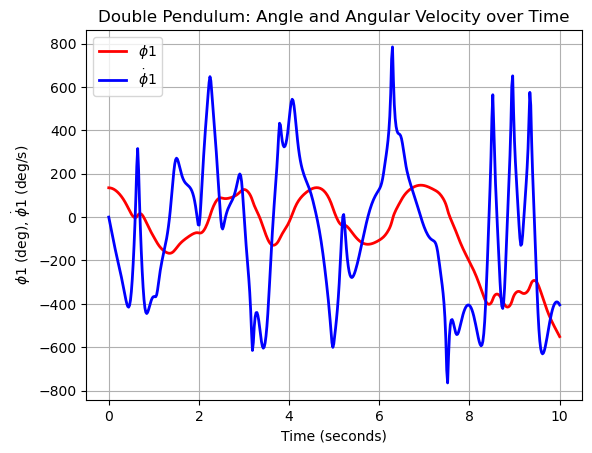

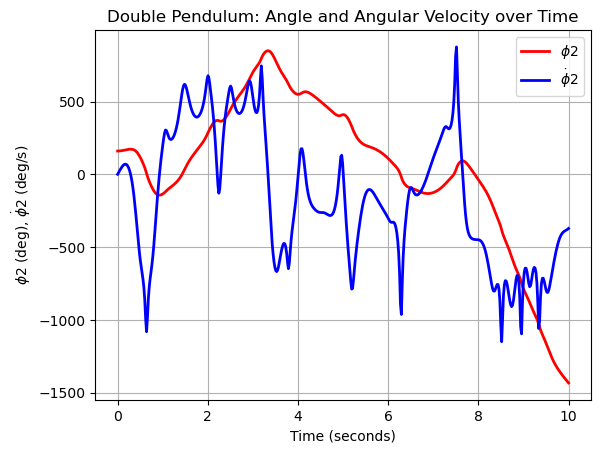

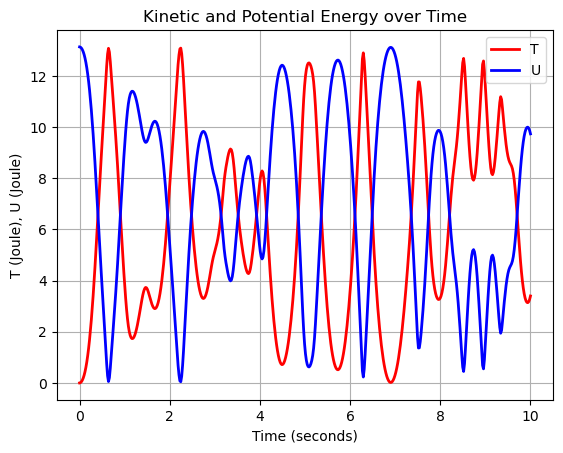

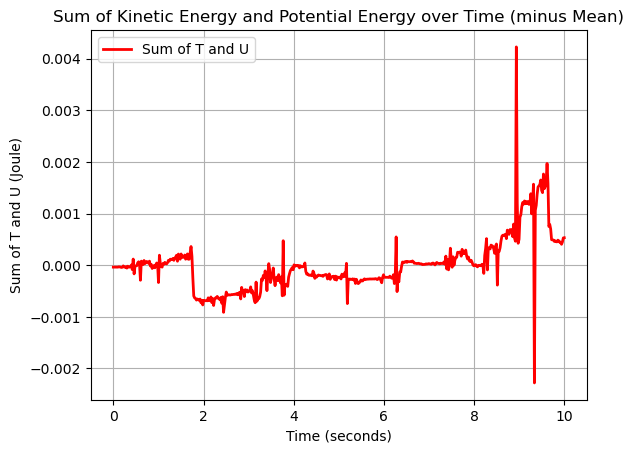


Mean of sum of T and U is: 13.130492330926081
Deviation is a maximum of 0.032205726646682996 percent in positive direction
Deviation is a maximum of 0.01737325618146324 percent in negative direction



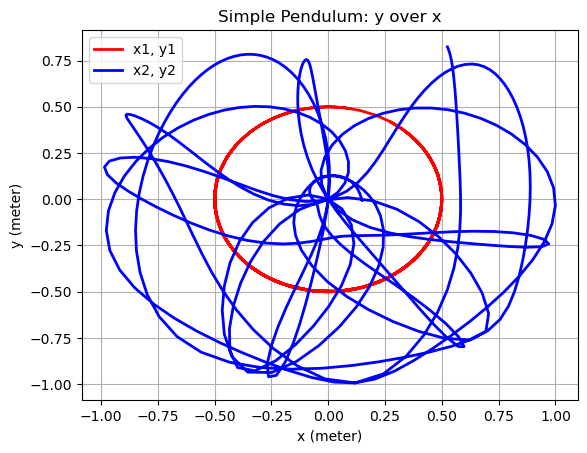

In [3]:

# plot of angle and angular velocity over time
plt.figure(1)
plt.plot(tt, phi1_deg, 'r', lw=2, label=r'$\phi1$')
plt.plot(tt, phid1_deg, 'b', lw=2, label=r'$\dot \phi1$')
plt.title('Double Pendulum: Angle and Angular Velocity over Time')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$\phi1$ (deg), $\dot \phi1$ (deg/s)')
plt.grid()
plt.show()

# plot of angle and angular velocity over time
plt.figure(2)
plt.plot(tt, phi2_deg, 'r', lw=2, label=r'$\phi2$')
plt.plot(tt, phid2_deg, 'b', lw=2, label=r'$\dot \phi2$')
plt.title('Double Pendulum: Angle and Angular Velocity over Time')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$\phi2$ (deg), $\dot \phi2$ (deg/s)')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------------------------------------------------ #

# plot of kinetic energy T and potential energy U over time
plt.figure(3)
plt.plot(tt, T_sol, 'r', lw=2, label='T')
plt.plot(tt, U_sol, 'b', lw=2, label='U')
plt.title('Kinetic and Potential Energy over Time')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'T (Joule), U (Joule)')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------------------------------------------------ #

# calculate mean from sum of T and U -> controll if numerical simulation was sucessful (great shifts would be a hint for bad simulation results)
# mean substracted in following plot to visualize only the deviation from zero -> ideally should be zero but small deviations are okay
mean_T_plus_U = np.mean(T_sol+U_sol)

# plot of deviation of sum of T and U over time
plt.figure(4)
plt.plot(tt, T_sol + U_sol - mean_T_plus_U, 'r', lw=2, label='Sum of T and U')
plt.title('Sum of Kinetic Energy and Potential Energy over Time (minus Mean)')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Sum of T and U (Joule)')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------------------------------------------------ #

# determine maximum positive and negative deviation; return both values as a positive percent value
max_error = (abs(max(T_sol + U_sol - mean_T_plus_U))/mean_T_plus_U)*100
min_error = (abs(min(T_sol + U_sol - mean_T_plus_U))/mean_T_plus_U)*100

print("")
print("Mean of sum of T and U is:", mean_T_plus_U)
print("Deviation is a maximum of", max_error, "percent in positive direction")
print("Deviation is a maximum of", min_error, "percent in negative direction")
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# plot y over x values
plt.figure(5)
plt.plot(x1, y1, 'r', lw=2, label='x1, y1')
plt.plot(x2, y2, 'b', lw=2, label='x2, y2')
plt.title('Simple Pendulum: y over x')
plt.legend()
plt.xlabel('x (meter)')
plt.ylabel('y (meter)')
plt.grid()
plt.show()


In [5]:

# animation of angles over time; angels are drawn in "real-time"

# ------------------------------------------------------------------------------------------------------------------------ #

# import necessary packages
from IPython.display import HTML

# ------------------------------------------------------------------------------------------------------------------------ #

# define animate function; in each iteration i one pair of data is appended and displayed over again in each step
def animate_angle(i):
    phi1_curve.set_data(tt[:i+1], phi1_deg[:i+1])
    phi2_curve.set_data(tt[:i+1], phi2_deg[:i+1])

# ------------------------------------------------------------------------------------------------------------------------ #

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

fig, ax = plt.subplots()

#initialize the curves with first values
phi1_curve, = ax.plot(tt[0], phi1_deg[0], 'r')
phi2_curve, = ax.plot(tt[0], phi2_deg[0], 'b')

# determine absolute maximum value for scaling of plot
max_1 = max(phi1_deg)
max_2 = max(phi2_deg)
min_1 = abs(min(phi1_deg))
min_2 = abs(min(phi2_deg))

max_all = max(max_1, max_2, min_1, min_2)

# define properties of ax from animation
ax.set_title('Double Pendulum: Angle over Time')
ax.set_xlim(tt[0], tt[-1])
ax.set_ylim(-max_all, max_all)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel(r'$\phi1$ (deg), $\phi2$ (deg)')
ax.legend([r'$\phi1$', r'$\phi2$'])
ax.grid(1)

# ------------------------------------------------------------------------------------------------------------------------ #

# cretae animation within fig with function animate and some parameters
# interval approximated so that animation takes roughly the same time as simulated for a real time effect
ani_angle = animation.FuncAnimation(fig, animate_angle, frames=len(tt), interval=1000 * tt.max() / len(tt))

# prevents additional static plot that is not used
plt.close()

# open animation with this line
HTML(ani_angle.to_jshtml())

# save animation as gif to document results; dpi could be varied; do not change fps value: otherwise no real time behaviour!
from matplotlib.animation import FuncAnimation, PillowWriter
ani_angle.save("Double_Pendulum_angle.gif", dpi=300, writer=PillowWriter(fps=50))


In [6]:

# animation of angular velocity over time; angular velocities are drawn in "real-time"

# ------------------------------------------------------------------------------------------------------------------------ #

# import necessary packages
from IPython.display import HTML

# ------------------------------------------------------------------------------------------------------------------------ #

# define animate function; in each iteration i one pair of data is appended and displayed over again in each step
def animate_ang_vel(i):
    phid1_curve.set_data(tt[:i+1], phid1_deg[:i+1])
    phid2_curve.set_data(tt[:i+1], phid2_deg[:i+1])

# ------------------------------------------------------------------------------------------------------------------------ #

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

fig, ax = plt.subplots()

#initialize the curves with first values
phid1_curve, = ax.plot(tt[0], phid1_deg[0], 'r')
phid2_curve, = ax.plot(tt[0], phid2_deg[0], 'b')

# determine absolute maximum value for scaling of plot
maxd_1 = max(phid1_deg)
maxd_2 = max(phid2_deg)
mind_1 = abs(min(phid1_deg))
mind_2 = abs(min(phid2_deg))

maxd_all = max(maxd_1, maxd_2, mind_1, mind_2)

# define properties of ax from animation
ax.set_title('Double Pendulum: Angular Velocity over Time')
ax.set_xlim(tt[0], tt[-1])
ax.set_ylim(-maxd_all, maxd_all)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel(r'$\dot \phi1$ (deg/s), $\dot \phi2$ (deg/s)')
ax.legend([r'$\dot \phi1$', r'$\dot \phi2$'])
ax.grid(1)

# ------------------------------------------------------------------------------------------------------------------------ #

# cretae animation within fig with function animate and some parameters
# interval approximated so that animation takes roughly the same time as simulated for a real time effect
ani_ang_vel = animation.FuncAnimation(fig, animate_ang_vel, frames=len(tt), interval=1000 * tt.max() / len(tt))

# prevents additional static plot that is not used
plt.close()

# open animation with this line
HTML(ani_ang_vel.to_jshtml())

# save animation as gif to document results; dpi could be varied; do not change fps value: otherwise no real time behaviour!
from matplotlib.animation import FuncAnimation, PillowWriter
ani_ang_vel.save("Double_Pendulum_angular_velocity.gif", dpi=300, writer=PillowWriter(fps=50))


In [7]:

# animation of pendulum motion over time; motion is drawn in "real-time"

# ------------------------------------------------------------------------------------------------------------------------ #

# import necessary packages
from IPython.display import HTML

# ------------------------------------------------------------------------------------------------------------------------ #

# calculate pendulum position in x and y coordinates from angle and length of pendulum
def pend_pos(phi1, phi2):
    x1 = l1_par*np.sin(phi1)
    y1 = -l1_par*np.cos(phi1)
    x2 = l1_par*np.sin(phi1)+l2_par*np.sin(phi2)
    y2 = -l1_par*np.cos(phi1)-l2_par*np.cos(phi2)
    return x1, y1, x2, y2

# define animate function; in each iteration i one pair of data is displayed
def animate(i):
    x1, y1, x2, y2 = pend_pos(phi1[i], phi2[i])
    line1.set_data([0, x1], [0, y1])
    line2.set_data([x1, x2], [y1, y2])
    circle1.set_center((x1, y1))
    circle2.set_center((x2, y2))
  
# ------------------------------------------------------------------------------------------------------------------------ #

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

# create figure
fig = plt.figure()

# define properties of ax from animation
ax = fig.add_subplot(aspect='equal')
ax.set_xlim(-1.1*(l1_par+l2_par), 1.1*(l1_par+l2_par))
ax.set_ylim(-1.1*(l1_par+l2_par), 1.1*(l1_par+l2_par))
ax.set_title('Double Pendulum: Pendel Motion over Time')
ax.set_xlabel('x in m')
ax.set_ylabel('y in m')
ax.grid(1)

# determine start values for x and y and thus the line and circle
x10, y10, x20, y20 = pend_pos(phi1_par, phi2_par)
line1, = ax.plot([0, x10], [0, y10], lw=2, c='k')
line2, = ax.plot([x10, x20], [y10, y20], lw=2, c='k')
circle1 = ax.add_patch(plt.Circle((x10, y10), m1_par*0.05, fc='r', zorder=3))
circle2 = ax.add_patch(plt.Circle((x20, y20), m2_par*0.05, fc='r', zorder=3))

# ------------------------------------------------------------------------------------------------------------------------ #

# cretae animation within fig with function animate and some parameters
# interval approximated so that animation takes roughly the same time as simulated for a real time effect
ani = animation.FuncAnimation(fig, animate, frames=len(tt), interval=1000 * tt.max() / len(tt))

# prevents additional static plot that is not used
plt.close()

# open animation with this line
HTML(ani.to_jshtml())

# save animation as gif to document results; dpi could be varied; do not change fps value: otherwise no real time behaviour!
from matplotlib.animation import FuncAnimation, PillowWriter
ani.save("Double_Pendulum_motion.gif", dpi=300, writer=PillowWriter(fps=50))
